# Adder Example

This example walks through building and using bricks for a streaming adder.

Matplotlib is required for plotting the graphs below.

In [ ]:
import networkx as nx
import numpy as np
import fugu
from fugu import Scaffold, Brick
from fugu.bricks import Vector_Input
from fugu.backends import snn_Backend

This is a brick to perform the streaming adder shown in the image below

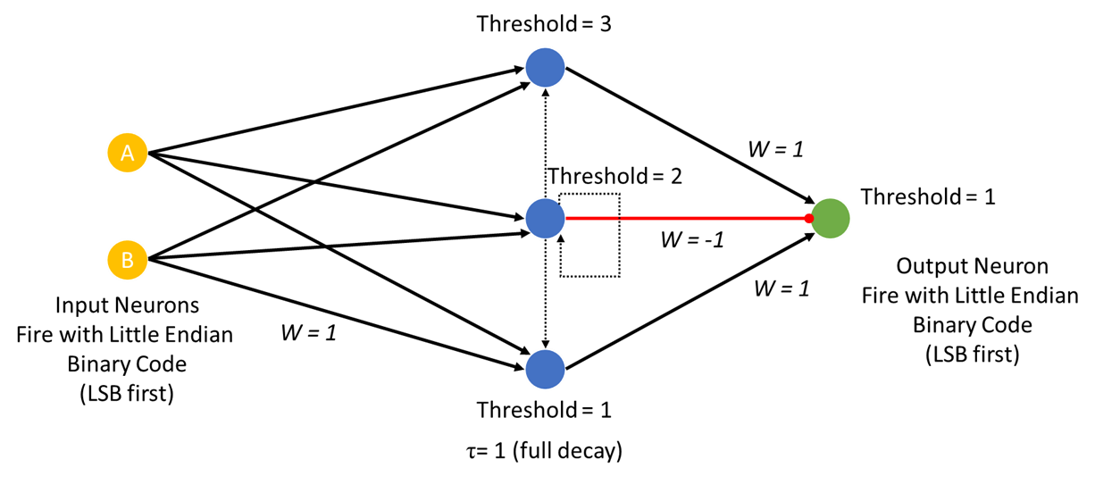



In [4]:
class streaming_adder(Brick):
    
    """
    streaming adder function. 
    Brad Aimone
    jbaimon@sandia.gov
    
    """
    
    def __init__(self, name=None):
        super().__init__()
        self.is_built = False
        self.dimensionality = {'D': 2}
        self.name = name
        self.supported_codings = ['binary-L']
        
    def build(self, graph, dimensionality, control_nodes, input_lists, input_codings):
        """
        Build streaming adder brick. 

        Arguments:
            + graph - networkx graph to define connections of the computational graph
            + dimensionality - dictionary to define the shapes and parameters of the brick
            + control_nodes - dictionary of lists of auxillary networkx nodes.  Excpected keys: 'complete' - A list of neurons that fire when the brick is done
            + input_lists - list of nodes that will contain input
            + input_coding - list of input coding formats

        Returns:
            + graph of a computational elements and connections
            + dictionary of output parameters (shape, coding, layers, depth, etc)
            + dictionary of control nodes ('complete')
            + list of output
            + list of coding formats of output
        """
        
        if len(input_codings) != 2:
            raise ValueError("adder takes in 2 input on size n")
            
        output_codings = [input_codings[0]]
        
        new_complete_node_name = self.name + '_complete'
        
        graph.add_node(new_complete_node_name,
                      index = -1,
                      threshold = 0.0,
                      decay =0.0,
                      p=1.0,
                      potential=0.0)

        graph.add_edge(control_nodes[0]['complete'], new_complete_node_name, weight=1.0, delay=2)

        complete_node = new_complete_node_name
        
        
        l = len(input_lists[0])
        
        #nodes
        graph.add_node(self.name + 'add', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry0', threshold=1.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry1', threshold=2.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'out', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        #edges
        graph.add_edge(input_lists[0][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry1', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'carry0', self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'add', self.name + 'out', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'out', weight=-1.0, delay=1)
        graph.add_edge(self.name + 'carry1', self.name + 'out', weight=1.0, delay=1)
        
        
        
        self.is_built=True
        
        output_lists = [[self.name + 'out']]
        
        return (graph, self.dimensionality, [{'complete': complete_node}], output_lists, output_codings)
    

The below brick performs a temporal bit shift of an input.  (There may be better ways to do this.)  

In binary little endian temporal spike coding, this temporal shift (delaying by +1) equates to a bit shift operation in binary (x<<a --> equivalent to  x 2**a)

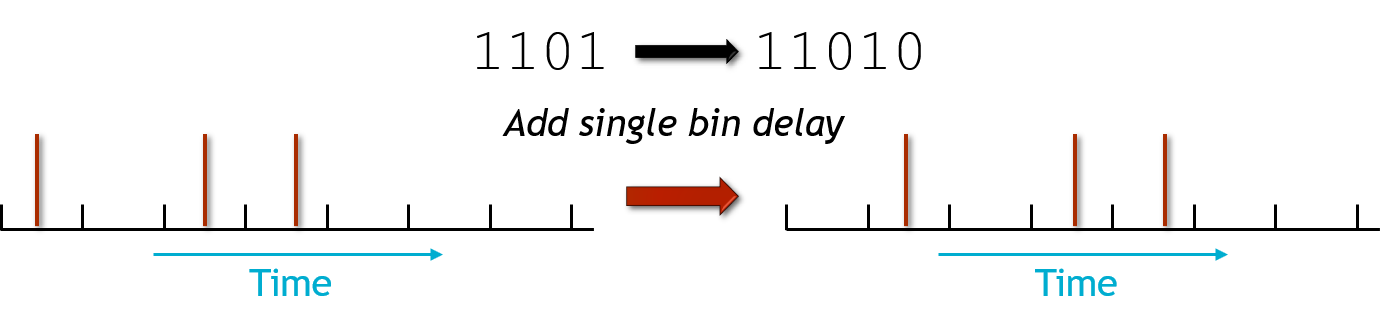

In [5]:
class temporal_shift(Brick):
    
    """
    temporal shift function. 
    Brad Aimone
    jbaimon@sandia.gov
    
    """
    
    def __init__(self, name=None, shift_length = 1):
        super().__init__()
        self.is_built = False
        self.dimensionality = {'D': 2}
        self.name = name
        self.supported_codings = ['binary-L']
        self.shift_length = shift_length
        
    def build(self, graph, dimensionality, control_nodes, input_lists, input_codings):
        """
        Build bit shift brick. 

        Arguments:
            + graph - networkx graph to define connections of the computational graph
            + dimensionality - dictionary to define the shapes and parameters of the brick
            + control_nodes - dictionary of lists of auxillary networkx nodes.  Excpected keys: 'complete' - A list of neurons that fire when the brick is done
            + input_lists - list of nodes that will contain input
            + input_coding - list of input coding formats

        Returns:
            + graph of a computational elements and connections
            + dictionary of output parameters (shape, coding, layers, depth, etc)
            + dictionary of control nodes ('complete')
            + list of output
            + list of coding formats of output
        """
        
        if len(input_codings) != 1:
            raise ValueError("bit_shift takes in 1 input on size n")
            
        output_codings = [input_codings[0]]
        
        new_complete_node_name = self.name + '_complete'
        
        graph.add_node(new_complete_node_name,
                      index = -1,
                      threshold = 0.0,
                      decay =0.0,
                      p=1.0,
                      potential=0.0)

        graph.add_edge(control_nodes[0]['complete'], new_complete_node_name, weight=1.0, delay=2)

        complete_node = new_complete_node_name
        
        
        l = len(input_lists[0])
        
        #nodes
        graph.add_node(self.name + 'out', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        #edges
        graph.add_edge(input_lists[0][0], self.name + 'out', weight=1.0, delay=self.shift_length)
        
        self.is_built=True
        
        output_lists = [[self.name + 'out']]
        
        return (graph, self.dimensionality, [{'complete': complete_node}], output_lists, output_codings)
    

In [6]:
# Simple addition example

scaffold = Scaffold()

# For addition, what we want to do is create a Scaffold taking two inputs and the adder brick

scaffold.add_brick(Vector_Input(np.array([[0, 1, 1, 0, 1, 0, 0, 0]]), coding='binary-L', name='Input0', time_dimension = True), 'input' )
scaffold.add_brick(Vector_Input(np.array([[0, 0, 0, 1, 1, 0, 1, 0]]), coding='binary-L', name='Input1', time_dimension = True), 'input' )
scaffold.add_brick(streaming_adder(name='adder1_'), [(0,0), (1, 0)], output=True)

scaffold.lay_bricks()
scaffold.summary(verbose=1)

backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(30)
print(result)

Scaffold is built: True
-------------------------------------------------------
List of Bricks:


Brick No.: 0
Brick Tag: Input0-0
Brick Name: Input0
{'tag': 'Input0-0', 'name': 'Input0', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7f94fa4e87f0>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input0-0:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 8)], 'output_coding': 'binary-L', 'layer': <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7f94f7753ac0>>, 'D': 0}, 'control_nodes': [{'complete': 'Input0-0:complete', 'begin': 'Input0-0:begin'}]}
Brick is built: True


Brick No.: 1
Brick Tag: Input1-1
Brick Name: Input1
{'tag': 'Input1-1', 'name': 'Input1', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7f94fa4e88b0>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input1-1:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 8)], 'output_coding': 'bin

This adder can then be assembled serially to provide a scalar multiplication.  This can be likely be turned into a brick itself, but is just listed as a scaffold below

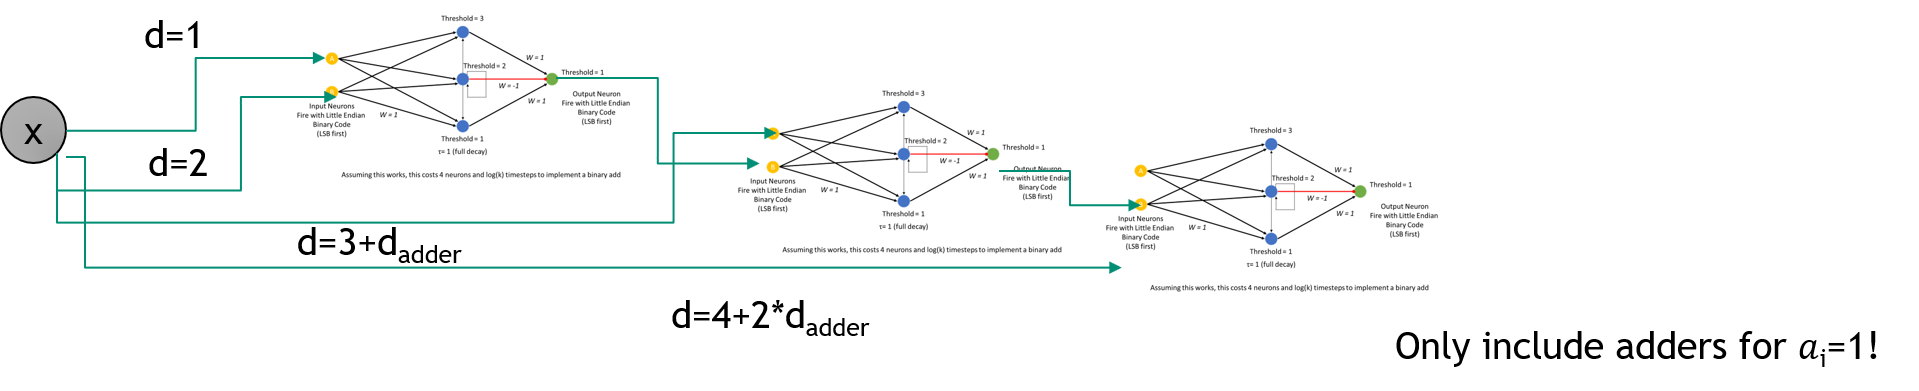

In [7]:
# Scalar multiplication example

scaffold = Scaffold()

alpha = .3125
bit_length = 8
# Convert alpha to little-endian binary
a1=bin(int(alpha*2**bit_length))[2:].zfill(bit_length)
a1=a1[::-1]
print(a1)


# For scalar multiplication, what we want to do is create a Scaffold taking the original input, x, and a zeros input
# 
# This is inefficient, but we will bit shift x to all possible stages.  But we will use the zeros input for each adder who place entry in the scalar is zero

scaffold.add_brick(Vector_Input(np.array([[0, 1, 1, 0, 1, 0, 0, 0]]), coding='binary-L', name='Input0', time_dimension = True), 'input' )
scaffold.add_brick(Vector_Input(np.array([[0, 0, 0, 0, 0, 0, 0, 0]]), coding='binary-L', name='Input_zeros', time_dimension = True), 'input' )

for i in range(1, bit_length):
    # Create a bit shifted version of 'x' for each of the place values of alpha
    scaffold.add_brick(temporal_shift(name='shift'+str(i)+'_', shift_length=1+3*(i-1)), [(0,0)], output=True)    

for i in range(1,bit_length):
    if(i==1):
        # First adder potentially takes in 'x' and 'x<<1'  Need to check if both are used; otherwise pass in zeros
        if(a1[i-1]=='1'):
            in_1=0
        else:
            in_1=1 # First place of scalar is empty, so pass in zeros
    else:
        # All other adders use previous adder as an input
        in_1=bit_length-1+i # 7+i
    if(a1[i]=='1'):
        # For each adder, check if element = 1, otherwise pass in zero as input
        in_2=1+i
    else:
        in_2=1
        
    #print(i, in_1, in_2)
    scaffold.add_brick(streaming_adder(name='adder_'+str(i)+'_'), [(in_1,0), (in_2, 0)], output=True)


scaffold.lay_bricks()
scaffold.summary(verbose=1)

00001010
Scaffold is built: True
-------------------------------------------------------
List of Bricks:


Brick No.: 0
Brick Tag: Input0-3
Brick Name: Input0
{'tag': 'Input0-3', 'name': 'Input0', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7f94fa4c9430>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input0-3:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 8)], 'output_coding': 'binary-L', 'layer': <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7f94f7753ac0>>, 'D': 0}, 'control_nodes': [{'complete': 'Input0-3:complete', 'begin': 'Input0-3:begin'}]}
Brick is built: True


Brick No.: 1
Brick Tag: Input_zeros-4
Brick Name: Input_zeros
{'tag': 'Input_zeros-4', 'name': 'Input_zeros', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7f94fa4c9af0>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input_zeros-4:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape

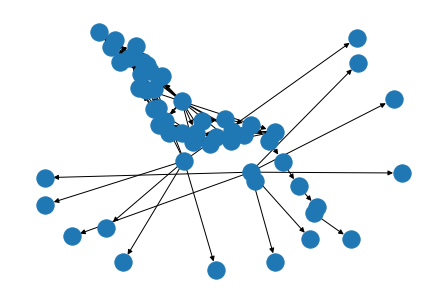

In [9]:
nx.draw(scaffold.graph)

scaffold = Scaffold()
scaffold.add_brick(Spike_Input(np.array([1,0,1,1]), coding='Raster', name='Input0'), 'input')
scaffold.add_brick(XOR(name='xor'), [0], output=True)
scaffold.lay_bricks()
result = scaffold.evaluate(backend='ds', max_runtime =9, record_all=True)
print(result)

In [10]:
backend = snn_Backend()
backend_args = {}
backend_args['record'] = '54'
backend.compile(scaffold, backend_args)
result = backend.run(30)
print(result)

    time  neuron_number
0    2.0            7.0
1    3.0            7.0
2    5.0            7.0
3    5.0            9.0
4    6.0            9.0
5    8.0            9.0
6    8.0           11.0
7    9.0           11.0
8   11.0           11.0
9   11.0           13.0
10  12.0           13.0
11  13.0           39.0
12  14.0           13.0
13  14.0           15.0
14  14.0           39.0
15  15.0           15.0
16  15.0           44.0
17  16.0           39.0
18  16.0           44.0
19  17.0           15.0
20  17.0           17.0
21  17.0           49.0
22  18.0           17.0
23  18.0           44.0
24  18.0           49.0
25  19.0           49.0
26  19.0           54.0
27  20.0           17.0
28  20.0           19.0
29  20.0           54.0
30  21.0           19.0
31  21.0           49.0
32  21.0           54.0
33  22.0           49.0
34  23.0           19.0
35  23.0           54.0
36  24.0           54.0
